# Example 1: Umbrella Sampling in 1D

In this example, we will perform umbrella sampling along the x-coordinate for a particle on a 2-dimensional potential energy surface, and construct a free energy profile from the biased umbrella sampling data using WHAM.

We will use OpenMM to perform langevin dynamics simulations of a particle on a 2-dimensional potential energy surface. To learn more about OpenMM, visit https://openmm.org/

The file `single_particle_ld.py` contains the classes we will use to run these simulations.

In [1]:
# Imports
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import WHAM
sys.path.append('.')
import single_particle_ld

## Visualize potential

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2


(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff1a2e55d90>)

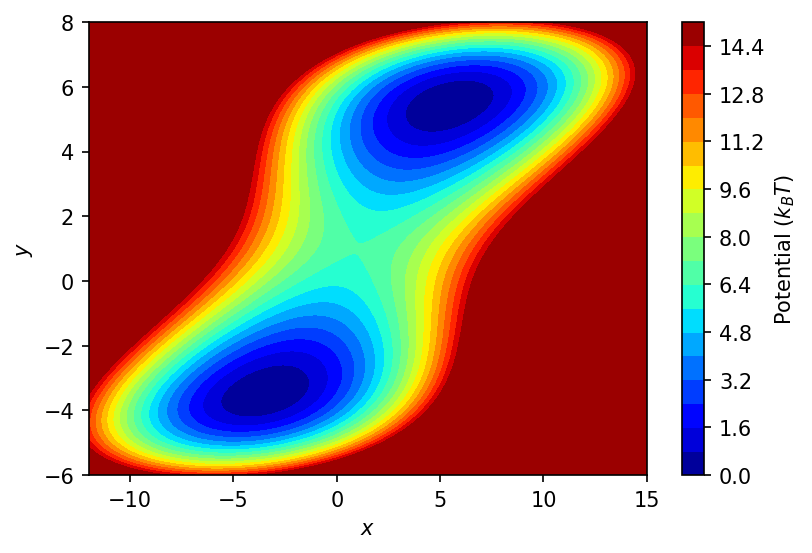

In [6]:
pot = single_particle_ld.TwoBasinPotential2D()
vis = single_particle_ld.VisualizePotential2D(pot, temp=300,
                                              xrange=[-12, 15], yrange=[-6, 8],
                                              contourvals=20, clip=15)
vis.plot_potential()

## Unbiased simulation

In [3]:
if not os.path.exists("examples_out/1D_US/unbiased"):
    os.makedirs("examples_out/1D_US/unbiased")
    
pot = single_particle_ld.TwoBasinPotential2D()

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  init_coord=np.array([[-5, -4, 0]]),
                                                  traj_in_mem=True,
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/unbiased/chk_state.pkl",
    trajfile="examples_out/1D_US/unbiased/traj.dat",
    energyfile="examples_out/1D_US/unbiased/energies.dat")

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
Running simulation on 1 CPU threads.


 23%|███████▉                          | 11711/50001 [00:00<00:02, 14308.04it/s]

Checkpoint at 100.0000000 ps


 41%|█████████████▊                    | 20382/50001 [00:01<00:02, 14386.49it/s]

Checkpoint at 200.0000000 ps


 63%|█████████████████████▍            | 31601/50001 [00:02<00:01, 13998.69it/s]

Checkpoint at 300.0000000 ps


 80%|████████████████████████████       | 40072/50001 [00:03<00:01, 9476.20it/s]

Checkpoint at 400.0000000 ps


100%|██████████████████████████████████| 50001/50001 [00:04<00:00, 12359.49it/s]

Checkpoint at 500.0000000 ps
Checkpoint at 500.0000000 ps


### Visualize trajectory in 2D

(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff1a2e58790>)

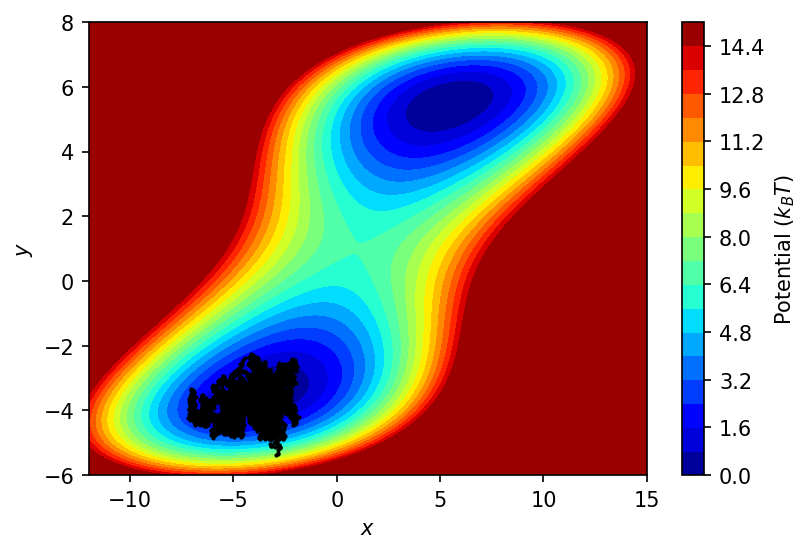

In [7]:
vis.scatter_traj(sim.traj)

### Visualize trajectory in 1D

100%|██████████████████████████████████████| 5001/5001 [00:19<00:00, 257.84it/s]


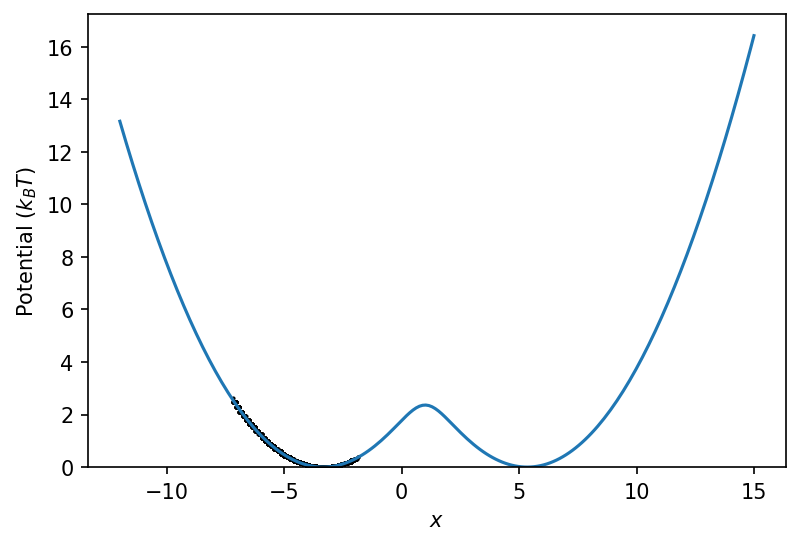

In [5]:
vis.scatter_traj_projection_x(sim.traj)

## Biased simulations

In [ ]:
if not os.path.exists("examples_out/1D_US/unbiased"):
    os.makedirs("examples_out/1D_US/unbiased")
    
pot = single_particle_ld.TwoBasinPotential2D()

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  init_coord=np.array([[-5, -4, 0]]),
                                                  traj_in_mem=True,
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/unbiased/chk_state.pkl",
    trajfile="examples_out/1D_US/unbiased/traj.dat",
    energyfile="examples_out/1D_US/unbiased/energies.dat")

## Binless WHAM

## Binned WHAM